In [1]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, TimeDistributed, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from collections import Counter
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, mean_squared_error, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error

from datetime import datetime
import plotly  as py
py.tools.set_credentials_file(username='mcmanusdatascience', api_key='Mkw1SmxGJj1HPglRqBES')
import plotly.graph_objs as go
import plotly.tools as tls

from numpy import concatenate

import warnings
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime as dt
from datetime import date
import re
from sklearn import preprocessing
import scipy.stats  as stats

from math import sqrt

In [3]:
#import data and 
atvi = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\atvi_master_final_2.csv')
atvi.Date = pd.to_datetime(atvi.Date)
atvi.index = atvi.Date

#split data for training and testing

train  = atvi.loc[:'2018-11-02']
test  = atvi.loc['2018-11-02':]

In [4]:
# split data for training and testing. 
# on nov 2nd 2018 the activision stock was just about to fall pretty hard. let's see if our model can predict this.

atvi_train_nov2nd2018 = atvi.loc[:'11/2/2018']
atvi_test_nov2nd2018 = atvi.loc['11/2/2018':]

In [5]:
#get df with only feature variables
atvi_train_nov2nd2018_fv = atvi_train_nov2nd2018[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
atvi_test_nov2nd2018_fv = atvi_test_nov2nd2018[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]

In [6]:
# convert series to supervised learning (not my code)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# reshape data if needed
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# put data into a matrix
train_values = atvi_train_nov2nd2018_fv.values
test_values = atvi_test_nov2nd2018_fv.values

In [8]:
#scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.fit_transform(test_values)

In [9]:
#  data appropriately for lstm
train_reframed = series_to_supervised(train_scaled, 1, 1)
test_reframed = series_to_supervised(test_scaled, 1, 1)

In [10]:
# split into input and outputs - want 2-7 in X, 1 in Y
# remember we do not want to show the current day close prices to this model
train_reframed_x = train_reframed[['var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)', 'var6(t-1)','var7(t-1)']]
test_reframed_x = test_reframed[['var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)', 'var6(t-1)', 'var7(t-1)']]
#set up y variables for open and close data
train_reframed_y_close = train_reframed[['var1(t)']]
test_reframed_y_close = test_reframed[['var1(t)']]

In [11]:
# put the dataframe into a matrix
train_reframed_x = train_reframed_x.values
test_reframed_x = test_reframed_x.values
train_reframed_y_close = train_reframed_y_close.values
test_reframed_y_close = test_reframed_y_close.values

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_reframed_x.reshape((train_reframed_x.shape[0], 1, train_reframed_x.shape[1]))
test_X = test_reframed_x.reshape((test_reframed_x.shape[0], 1, test_reframed_x.shape[1]))
print(train_X.shape, train_reframed_y_close.shape, test_X.shape, test_reframed_y_close.shape)

(760, 1, 6) (760, 1) (155, 1, 6) (155, 1)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 6 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent. Adam is an adapted, quicker version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 31 (1 month). The internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days might provide some added utility in this model.

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [13]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_reframed_y_close, epochs=8, batch_size=31, validation_data=(test_X, test_reframed_y_close), verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 760 samples, validate on 155 samples
Epoch 1/8
 - 13s - loss: 0.3477 - val_loss: 0.1311
Epoch 2/8
 - 0s - loss: 0.2406 - val_loss: 0.1937
Epoch 3/8
 - 0s - loss: 0.2483 - val_loss: 0.2190
Epoch 4/8
 - 0s - loss: 0.2509 - val_loss: 0.2276
Epoch 5/8
 - 0s - loss: 0.2494 - val_loss: 0.2336
Epoch 6/8
 - 0s - loss: 0.2482 - val_loss: 0.2366
Epoch 7/8
 - 0s - loss: 0.2458 - val_loss: 0.2404
Epoch 8/8
 - 0s - loss: 0.2435 - val_loss: 0.2448


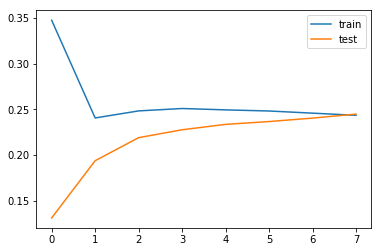

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# make a prediction
predictedclosingprice = model.predict(test_X)
#invert scaling - inverse transform needs to be fed an array of the same shape as before (155, 7)
#replace the actual Y values with the predicted ones and we will be good to go)
test_X1 = test_X.reshape((155,6))
inv_yhat = concatenate((predictedclosingprice, test_X1), axis=1)
# invert scaling for forecast - an array of shape 156, 7 was fed in originally. so i'm assuming I should do the same here.
inv_y_all = scaler.inverse_transform(inv_yhat)
inv_y = inv_y_all[:,0]

In [16]:
#test_y = test_y.reshape((len(test_y), 1))
actualval = concatenate((test_reframed_y_close, test_X1), axis=1)
actualval = scaler.inverse_transform(actualval)
actualval = actualval[:,0]

In [17]:
#model metric
rmse = sqrt(mean_squared_error(inv_y, actualval))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.097


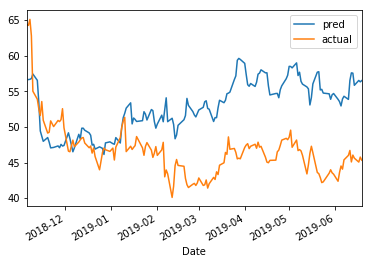

In [18]:
predictedvsactual = pd.DataFrame(atvi.Close.loc['2018-11-05':])
predictedvsactual['pred'] = inv_y
predictedvsactual['actual'] = actualval
predictedvsactual['pred'] = predictedvsactual['pred'].shift(1)
predictedvsactual = predictedvsactual.drop(columns = ['Close'], axis=1)
predictedvsactual.plot()

Provisionally, this looks quite good in predicting volatility and stock price direction movement. Let's take a closer look at what exactly is going on here:

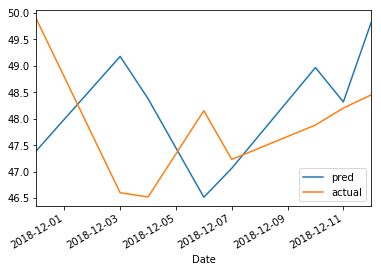

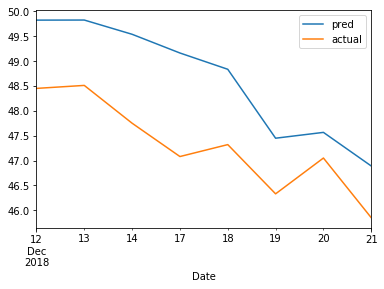

In [19]:
predictedvsactual.loc['2018-11-30':'2018-12-12'].plot()
predictedvsactual.loc['2018-12-12':'2018-12-22'].plot()

On initial inspection:

- RMSE is lower than the RF models. This is a good thing.

- We are not showing this model the stock price at any point. Accordingly, we are removing that potential bias and current day foward projection that we saw in the RF models.

- The model isn't predicting the stock price completely accurately. It is however predicting the volatility and directional movement of the stock price.

As we had our RF model also predict the price 5 days into the future let's attempt this aswell. 

Let's also take a look at what happens when we adapt the model as a classifier.

In [20]:
# Generate model that predicts stock price movement 5 days out and compare

In [21]:
#  data appropriately for lstm
atvi_lstm = atvi[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 5
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [22]:
reframedtrain = reframed[:760]
reframedtest = reframed[760:]

In [23]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [24]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [25]:
#setup training and test data
train_X = reframedtrain.drop(columns=[35,28,21,14,7,0,36,37,38,39,40,41])
test_X = reframedtest.drop(columns=[35,28,21,14,7,0,36,37,38,39,40,41])

train_Y = reframedtrain.iloc[:,35]
test_Y = reframedtest.iloc[:,35]

In [26]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 5, 6))
test_X = test_X.reshape((test_X.shape[0], 5, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(760, 5, 6) (760,) (151, 5, 6) (151,)


In [28]:
train_X.shape

(760, 5, 6)

In [29]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=20, batch_size=31, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 760 samples, validate on 151 samples
Epoch 1/20
 - 1s - loss: 0.1026 - val_loss: 0.5690
Epoch 2/20
 - 0s - loss: 0.4169 - val_loss: 0.2067
Epoch 3/20
 - 0s - loss: 0.2473 - val_loss: 0.2507
Epoch 4/20
 - 0s - loss: 0.2548 - val_loss: 0.2840
Epoch 5/20
 - 0s - loss: 0.2582 - val_loss: 0.3039
Epoch 6/20
 - 0s - loss: 0.2477 - val_loss: 0.3400
Epoch 7/20
 - 0s - loss: 0.2470 - val_loss: 0.3596
Epoch 8/20
 - 0s - loss: 0.2371 - val_loss: 0.3746
Epoch 9/20
 - 0s - loss: 0.2261 - val_loss: 0.3899
Epoch 10/20
 - 0s - loss: 0.2342 - val_loss: 0.3752
Epoch 11/20
 - 0s - loss: 0.2113 - val_loss: 0.3997
Epoch 12/20
 - 0s - loss: 0.2325 - val_loss: 0.3759
Epoch 13/20
 - 0s - loss: 0.2026 - val_loss: 0.4004
Epoch 14/20
 - 0s - loss: 0.2327 - val_loss: 0.3692
Epoch 15/20
 - 0s - loss: 0.1958 - val_loss: 0.4017
Epoch 16/20
 - 0s - loss: 0.2298 - val_loss: 0.3714
Epoch 17/20
 - 0s - loss: 0.1937 - val_loss: 0.3998
Epoch 18/20
 - 0s - loss: 0.2260 - val_loss: 0.3736
Epoch 19/20
 - 0s - loss: 0

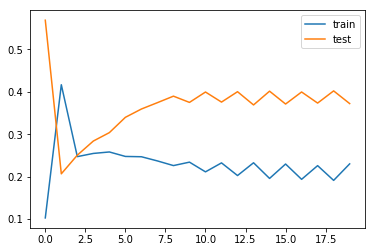

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
#loss function converges for test and train data around 3-4 epochs so let's run with that.

In [32]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=4, batch_size=31, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 760 samples, validate on 151 samples
Epoch 1/4
 - 1s - loss: 0.1212 - val_loss: 0.5970
Epoch 2/4
 - 0s - loss: 0.4547 - val_loss: 0.2148
Epoch 3/4
 - 0s - loss: 0.2720 - val_loss: 0.2378
Epoch 4/4
 - 0s - loss: 0.2615 - val_loss: 0.2731


In [33]:

# reinitate original dataframe so we can inversely transform the predictions
reframed = series_to_supervised(atvi_lstm_matrix, 5, 1)
reframedtest1 = reframed[760:]
real = reframedtest1['var1(t)']
# make a prediction - append it to original dataframe
predictedclosingprice = model.predict(test_X)
reframedtest1['var1(t)'] = predictedclosingprice
# invert scaling for forecast 
inv_y_all = scaler.inverse_transform(reframedtest1)
predicted = inv_y_all[:,35]


In [34]:
#new dataframe to compare predicted versus actual

predvsactual = pd.DataFrame()
predvsactual['real'] = real
predvsactual['pred'] = predicted
# the fact that the predicted data is the predicted price for 5 days in the future needs to be accounted for
predvsactual['pred'] = predvsactual['pred'].shift(5)


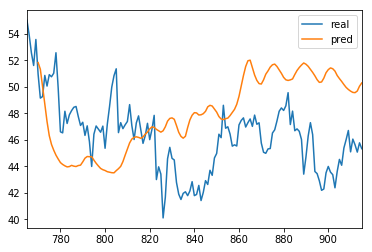

In [35]:
predvsactual.plot()

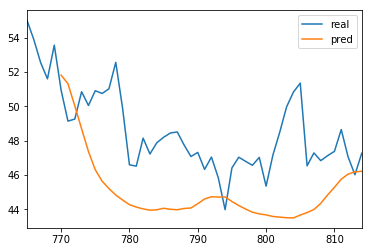

In [36]:
predvsactual.iloc[0:50].plot()

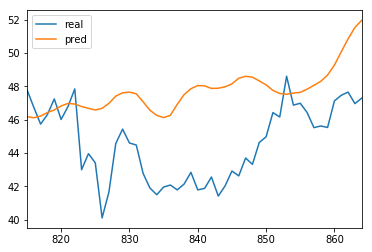

In [37]:
predvsactual.iloc[50:100].plot()

In [38]:
#model metric
rmse = sqrt(mean_squared_error(predvsactual['real'].loc[775:], predvsactual['pred'].loc[775:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.489


This model is not catching the huge downturn in the stock price. It is however catching other trends. Notably, we are getting a further decrease in RMSE.

It is alot more smoothed than the 1 day model. Of note is that this model is not predicting 5 days into the future. It is predicting the next day using the previous 5 days. In this sense, this model is a good comparator for our RF model. That being said, we are maintaing some intrinsic weaknesses to the utility of this model. It also seems that given that the LSTM is not picking up on the downturn of this stock. It would be reasonable to adapt the point at which we split the test and train groups.


Let's try a model that predicts 5 days into the future using the preceeding 14 days.

In [64]:
#  data appropriately for lstm
atvi_lstm = atvi[['Close','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 19
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [40]:
# our first predicted date should be 2015-11-24	36.840000 - this should correpond to column 133
#unhash the line below to double check this
#reframed.iloc[:,133]

In [65]:
# reset the train test split to move it foward
reframedtrain = reframed[:815]
reframedtest = reframed[815:]

In [66]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [67]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [68]:
#setup training and test data
train_X = reframedtrain.drop(columns=[56,63,70,77,84,91,98,105,112,119,126,133,49,42,35,28,21,14,7,0,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139])
test_X = reframedtest.drop(columns=[56,63,70,77,84,91,98,105,112,119,126,133,49,42,35,28,21,14,7,0,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139])

train_Y = reframedtrain.iloc[:,133]
test_Y = reframedtest.iloc[:,133]

In [69]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [70]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 16, 6))
test_X = test_X.reshape((test_X.shape[0], 16, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(815, 16, 6) (815,) (82, 16, 6) (82,)


In [71]:
train_X.shape

(815, 16, 6)

In [84]:
# design network
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=6, batch_size=15, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 815 samples, validate on 82 samples
Epoch 1/6
 - 6s - loss: 0.1233 - val_loss: 0.1706
Epoch 2/6
 - 2s - loss: 0.1112 - val_loss: 0.1937
Epoch 3/6
 - 2s - loss: 0.1286 - val_loss: 0.2432
Epoch 4/6
 - 2s - loss: 0.1673 - val_loss: 0.1692
Epoch 5/6
 - 2s - loss: 0.1439 - val_loss: 0.1693
Epoch 6/6
 - 2s - loss: 0.1544 - val_loss: 0.1683


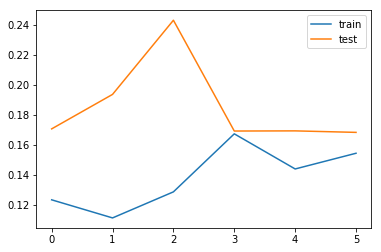

In [85]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [86]:

# reinitate original dataframe so we can inversely transform the predictions
reframed = series_to_supervised(atvi_lstm_matrix, 19, 1)
reframedtest1 = reframed[815:]
real = reframedtest1['var1(t)']
# make a prediction - append it to original dataframe
predictedclosingprice = model.predict(test_X)
reframedtest1['var1(t)'] = predictedclosingprice
# invert scaling for forecast 
inv_y_all = scaler.inverse_transform(reframedtest1)
predicted = inv_y_all[:,133]

In [87]:
#new dataframe to compare predicted versus actual

predvsactual = pd.DataFrame()
predvsactual['real'] = real
predvsactual['pred'] = predicted
# the fact that the predicted data is the predicted price for n days in the future needs to be accounted for
predvsactual['real'] = predvsactual['real']
predvsactual['pred'] = predvsactual['pred'].shift(+16)

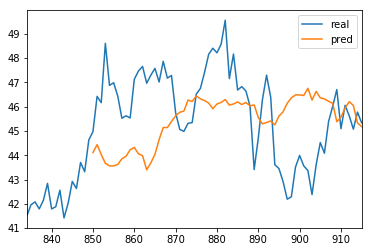

In [88]:
predvsactual.plot()

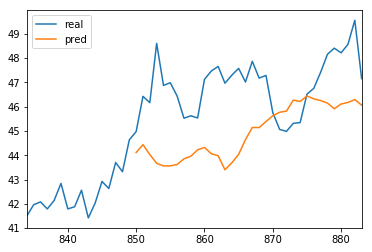

In [89]:
predvsactual.iloc[0:50].plot()

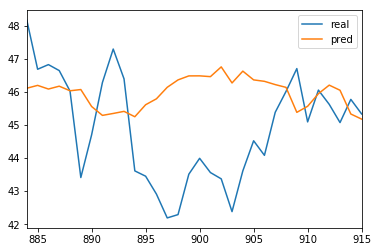

In [90]:
predvsactual.iloc[50:100].plot()

In [91]:
#model metric
rmse = sqrt(mean_squared_error(predvsactual['real'].loc[850:], predvsactual['pred'].loc[850:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.263


Based on RMSE this is our best model yet, further more we're truly predicting 5 days into the future with the model. The features for this model are a 14 day series of features whose recording date ends 5 days prior to the prediction. According, there is a 5 day window to adjust one's trading strategy.

As we attempted to predict stock price directional movement with our RF models. We will attempt the same here, before deciding on our final model. Let's attempt to predict 5 Day Directional Change.

In [56]:
#  data appropriately for lstm
atvi_lstm = atvi[['5daydirectionchange','roc','williams_R','so','rsi','macd_val', '7day_peaks']]
#put in matrix
atvi_lstm_matrix = atvi_lstm.values

# specify the number of lag hours
n_days = 15
# frame as supervised learning
reframed = series_to_supervised(atvi_lstm_matrix, n_days, 1)

In [57]:
# reset the train test split to move it foward
reframedtrain = reframed[:840]
reframedtest = reframed[840:]

In [58]:
#normalize data
reframedtrain = scaler.fit_transform(reframedtrain)
reframedtest = scaler.fit_transform(reframedtest)

In [59]:
#put reframed data back in in dataframe for ease of indexing
reframedtrain = pd.DataFrame(reframedtrain)
reframedtest = pd.DataFrame(reframedtest)

In [60]:
#setup training and test data
train_X = reframedtrain.drop(columns=[56,63,70,77,84,91,98,105,49,42,35,28,21,14,7,0,])
test_X = reframedtest.drop(columns=[56,63,70,77,84,91,98,105,49,42,35,28,21,14,7,0,])

train_Y = reframedtrain.iloc[:,105]
test_Y = reframedtest.iloc[:,105]

In [61]:
#put data in matrix so that we can pipe it into our model
train_X = train_X.values
test_X = test_X.values
train_Y = train_Y.values
test_Y = test_Y.values

In [62]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 16, 6))
test_X = test_X.reshape((test_X.shape[0], 16, 6))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(840, 16, 6) (840,) (61, 16, 6) (61,)


In [63]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=1000, batch_size=20, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Train on 840 samples, validate on 61 samples
Epoch 1/1000
 - 2s - loss: 0.5217 - val_loss: 0.5345
Epoch 2/1000
 - 1s - loss: 0.5155 - val_loss: 0.5373
Epoch 3/1000
 - 1s - loss: 0.4702 - val_loss: 0.5387
Epoch 4/1000
 - 1s - loss: 0.4843 - val_loss: 0.5440
Epoch 5/1000
 - 1s - loss: 0.4607 - val_loss: 0.5447
Epoch 6/1000
 - 1s - loss: 0.4756 - val_loss: 0.5508
Epoch 7/1000
 - 1s - loss: 0.4661 - val_loss: 0.5504
Epoch 8/1000
 - 1s - loss: 0.4523 - val_loss: 0.5467
Epoch 9/1000
 - 1s - loss: 0.4658 - val_loss: 0.5530
Epoch 10/1000
 - 1s - loss: 0.4565 - val_loss: 0.5457
Epoch 11/1000
 - 1s - loss: 0.4533 - val_loss: 0.5491
Epoch 12/1000
 - 1s - loss: 0.4542 - val_loss: 0.5428
Epoch 13/1000
 - 1s - loss: 0.4508 - val_loss: 0.5432
Epoch 14/1000
 - 1s - loss: 0.4479 - val_loss: 0.5430
Epoch 15/1000
 - 1s - loss: 0.4462 - val_loss: 0.5448
Epoch 16/1000
 - 1s - loss: 0.4474 - val_loss: 0.5421
Epoch 17/1000
 - 1s - loss: 0.4479 - val_loss: 0.5403
Epoch 18/1000
 - 1s - loss: 0.4452 - val_loss:

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

It seems the Neural Network model can learn to pick up the intricacies of how these features move in series and how this correlates with subsequent stock price movement. This model may have some utility and should be back tested. 